In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

### Note: code also uploaded to github. https://github.com/Haiyun314/Image_processing/tree/main

## Histogram

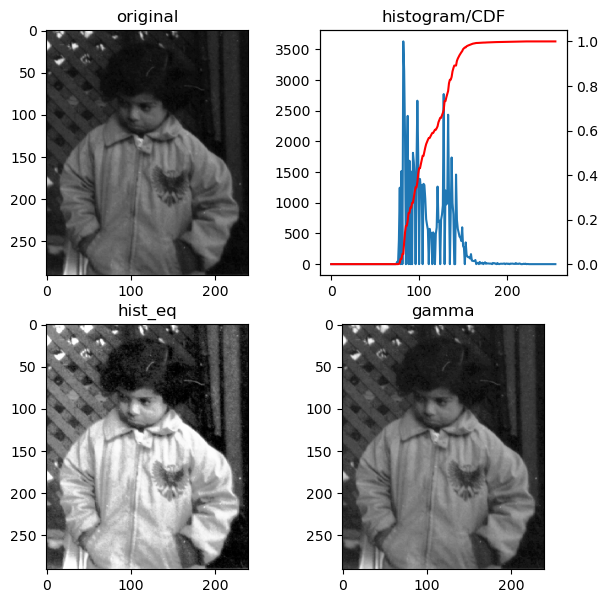

In [5]:
def my_hist(image, nbins: int):
    assert 255 >= nbins >= 1, 'numbers of bins should be larger than 1'
    num_bins = dict()           
    shape = image.shape
    histogram = [np.count_nonzero(image == i) for i in range(256)]
    h = int(np.floor(255/nbins))
    if nbins == 255:
        return histogram, np.array(histogram)/(shape[0] * shape[1])
    else:
        for k in range(nbins):
            try: 
                num_bins[k] = np.sum(histogram[k*h : (k+1) * h])
            except IndexError:
                num_bins[k] = np.sum(histogram[k*h :])
        histogram = np.array(list(num_bins.values()))
        return histogram, histogram/(shape[0]*shape[1])


def linear_transform(image, rectify_range: tuple, target_range:tuple):
    mask = np.logical_and(image <= rectify_range[1], image >= rectify_range[0])
    rectify = mask * rectify_range[0]
    return (image - rectify) / (rectify_range[1] - rectify_range[0]) * (target_range[1] - target_range[0]) + target_range[0]


def gamma_transform(image, gama):
    assert gama > 0, 'gama must be larger than zero, if the image is too dark,'
    'choose gama smaller than 1, if the image is too bright, choose gama larger than 1'
    return np.array(255 * np.power(image/255, gama), np.int32)

def histogram_equalization(image, gray_level, relative_hist):
    shape = image.shape
    eq_image = np.empty(shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            eq_image[i, j] = (gray_level) * np.sum(relative_hist[: image[i,j]])
    return eq_image

def cumulative_distribution_function(relative_hist):
    cdf = dict()
    for i in range(len(relative_hist)):
        cdf[i] = np.sum(relative_hist[:i])
    return cdf


if __name__ == '__main__':
    path = os.getcwd() + '/images/' + 'pout.png'
    image = plt.imread(path)
    image = np.array(image[:, :] * 255, np.int32)


    histogram, relative_hist = my_hist(image, 255)
    cdf = cumulative_distribution_function(relative_hist)
    hist_eq = histogram_equalization(image, 1, relative_hist)
    linear = linear_transform(image, (50, 150), (0, 255))
    gamma = gamma_transform(image, 0.3)


    _, ax = plt.subplots(2, 2, figsize = (7, 7))
    ax[0, 0].imshow(image, cmap= 'gray')
    ax[0, 0].set_title('original')

    ax[0, 1].plot([i for i in range(len(histogram))], histogram)
    second_axies = ax[0, 1].twinx()
    second_axies.plot(cdf.keys(), cdf.values(), c='red')
    ax[0, 1].set_title('histogram/CDF')

    ax[1, 0].imshow(hist_eq, cmap= 'gray')
    ax[1, 0].set_title('hist_eq')

    ax[1, 1].imshow(gamma, cmap= 'gray')
    ax[1, 1].set_title('gamma')
    plt.savefig('results/histogram.png')
    plt.show()


## Upscaling

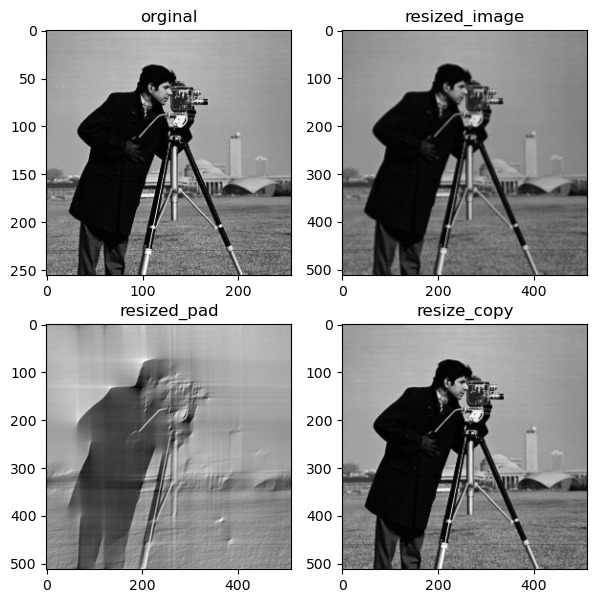

In [8]:
class Filters:
    @staticmethod
    def tent(x):
        if np.abs(x) <= 1:
            return 1 - np.abs(x)
        else:
            return 0
    
    @staticmethod
    def bell(x):
        if np.abs(x) <= 1/2:
            return -np.power(x, 2) + 3/4
        elif 1/2 < np.abs(x) < 3/2:
            return 1/2*np.square(np.abs(x) - 3/2)
        else:
            return 0
    
    @staticmethod
    def mitchell_netravali(x):
        if np.abs(x) < 1:
            return 7/6 * np.power(x, 3) - 2 * np.square(x) + 8/9
        elif 1 <= np.abs(x) < 2:
            return -7/18 * np.power(np.abs(x), 3) + 2 * np.square(x) - 10/3 * x + 16/9
        else :
            return 0


def resize_copy(image: np.ndarray, factor: int):
    shape = image.shape
    target_shape = (shape[0]*factor, shape[1]*factor)
    assert 1 <= factor, 'the factor should be large or equal to one'
    template = np.zeros(shape= target_shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            template[factor*i: (i+1)*factor, j*factor: (j +1)* factor] = image[i, j]
    return template


def i_zeropad(image: np.ndarray, factor: int):
    fft_image = np.fft.fft2(image)
    target_shape = (image.shape[0] * factor, image.shape[1] * factor)

    padded_fft_image = np.zeros(target_shape, dtype=fft_image.dtype)
    padded_fft_image[:image.shape[0]//2, :image.shape[1]//2] = fft_image[:image.shape[0]//2, :image.shape[1]//2]
    
    upscaled_image = np.fft.ifft2(padded_fft_image).real
    upscaled_image = upscaled_image[:image.shape[0] * factor, :image.shape[1] * factor]
    
    return upscaled_image


def interpolation_function(image: np.ndarray, x:float, y:float, filter:str):
    if filter == 'bell':
        f = Filters.bell
    elif filter == 'tent':
        f = Filters.tent
    elif filter == 'mitchell_netravali':
        f = Filters.mitchell_netravali
    x_, y_ = np.floor(x).astype(np.int32), np.floor(y).astype(np.int32)
    frac_x, frac_y = x-x_, y-y_
    try:
        inter_p0 = image[x_, y_] * f(1- frac_x) + image[x_ + 1, y_] * f(frac_x)
        inter_p1 = image[x_ , y_+1] * f(1 - frac_x) + image[x_ + 1, y_ + 1] * f(frac_x)
    except IndexError:
        inter_p0 = image[x_, y_] * f(1- frac_x) + image[x_, y_] * f(frac_x)
        inter_p1 = image[x_ ,y_] * f(1 - frac_x) + image[x_, y_] * f(frac_x)
    return inter_p0 * f(1 - frac_y) + inter_p1 * f(frac_y)


def resize_filter(image:np.ndarray, factor: int, filter: str):
    """ unfinished """
    shape = image.shape
    target_shape = (shape[0]*factor, shape[1]*factor)
    target_image = np.empty(target_shape)
    scale = (shape[0]/target_shape[0], shape[1]/target_shape[1])
    for i in range(target_shape[0]):
        for j in range(target_shape[1]):
            target_image[i, j] = interpolation_function(image, i * scale[0], j * scale[1], filter)
    return target_image

if __name__ == '__main__':
    path = os.getcwd() + '/images/cameraman.png'
    image = plt.imread(path)
    resized_image = resize_filter(image, 2,'mitchell_netravali')
    resized_pad = i_zeropad(image, 2)
    resized_copy = resize_copy(image, 2)

    plt.figure(figsize= (7, 7))
    plt.subplot(2, 2, 2)
    plt.imshow(resized_image, cmap= 'gray')
    plt.title('resized_image')
    plt.subplot(2, 2, 1)
    plt.title('orginal')
    plt.imshow(image, cmap= 'gray')
    plt.subplot(2, 2, 3)
    plt.imshow(resized_pad, cmap= 'gray')
    plt.title('resized_pad')
    plt.subplot(2, 2, 4)
    plt.title('resize_copy')
    plt.imshow(resized_copy, cmap= 'gray')
    plt.savefig('results/upscaling.png')
    plt.show()


## Filtering

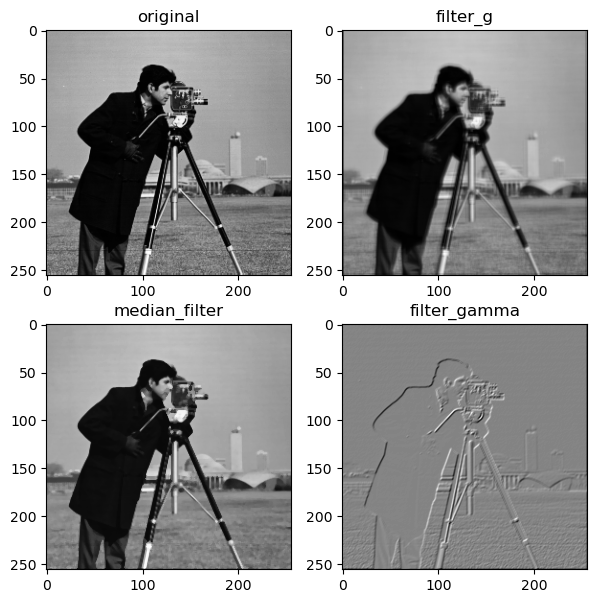

In [9]:
class Filters:
    @staticmethod
    def m():
        return 1/25 * np.ones(shape= (5, 5))
    
    @staticmethod
    def g():
        background = np.zeros(shape= (5, 5))
        for i in range(5):
            for j in range(5):
                background[i, j] = np.abs(3 - i) * np.abs(3 - j)
        return 1/81 * background
    
    @staticmethod
    def gamma():
        backgraound = np.zeros(shape=(3, 3))
        backgraound[0, 1] = -1
        backgraound[1, 0] = -1
        backgraound[1, 2] = 1
        backgraound[2, 1] = 1
        return backgraound
    
    @staticmethod
    def delta():
        backgraound = np.zeros(shape=(3, 3))
        backgraound[0, 1] = 1
        backgraound[1, 0] = 1
        backgraound[1, 2] = 1
        backgraound[2, 1] = 1
        backgraound[1, 1] = -4


def image_filter(image, filters: str):
    f = Filters
    try:
        if filters == 'm':
            filter = f.m()
        elif filters == 'g':
            filter = f.g()
        elif filters == 'gamma':
            filter = f.gamma()
        elif filters == 'delta':
            filter = f.delta()
    except NameError:
        raise 'please change the input name: m, g, gama or delta'
    padded_image = np.pad(image, pad_width= filter.shape[0]//2, constant_values= 0)
    template = np.zeros(shape = image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            template[i, j] = np.sum(np.multiply(padded_image[i: i + filter.shape[0], j: j + filter.shape[1]], filter))
    return template

def median_filter(image, size):
    padded_image = np.pad(image, pad_width= size[0]//2, constant_values= 0)
    template = np.zeros(shape= image.shape)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            template[i, j] = np.median(padded_image[i: i + size[0], j : j + size[1]])
    return template


if __name__ == '__main__':
    path = os.getcwd() + '/images/cameraman.png'
    image = plt.imread(path)
    image = image[:, :]

    f_image = image_filter(image, 'g')
    f_image_g = image_filter(image, 'gamma')
    m_image = median_filter(image, (3, 3))
    _, axes = plt.subplots(2, 2, figsize = (7, 7))
    axes[0, 0].imshow(image, cmap= 'gray')
    axes[0, 0].set_title('original')
    axes[0, 1].imshow(f_image, cmap= 'gray')
    axes[0, 1].set_title('filter_g')
    axes[1, 0].imshow(m_image, cmap= 'gray')
    axes[1, 0].set_title('median_filter')
    axes[1, 1].imshow(f_image_g, cmap= 'gray')
    axes[1, 1].set_title('filter_gamma')
    plt.savefig('./results/filters')
    plt.show()